<a href="https://colab.research.google.com/github/severine-baudry/P2_dog_classification/blob/VALID_9P/NN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog breed


## Download images

In [1]:
import os
dogpath="dog_images/" 
pwd = !pwd

check_data = False
if not os.path.exists(dogpath):
  !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
  !unzip -q dogImages.zip
  !mv dogImages dog_images


--2020-11-19 13:33:38--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  20.3MB/s    in 56s     

2020-11-19 13:34:34 (19.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



## Load and transform data

In [2]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [3]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
train_dir = os.path.join(dogpath, 'train/')
valid_dir = os.path.join(dogpath, 'valid/')
test_dir = os.path.join(dogpath, 'test/')


### transform data

In [5]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num valid images:  835
Num test images:  836


### Data loaders and data visualization

In [6]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [7]:
print(train_data.class_to_idx.items())
dog_labels = { v:k for k,v in train_data.class_to_idx.items()}

dict_items([('001.Affenpinscher', 0), ('002.Afghan_hound', 1), ('003.Airedale_terrier', 2), ('004.Akita', 3), ('005.Alaskan_malamute', 4), ('006.American_eskimo_dog', 5), ('007.American_foxhound', 6), ('008.American_staffordshire_terrier', 7), ('009.American_water_spaniel', 8), ('010.Anatolian_shepherd_dog', 9), ('011.Australian_cattle_dog', 10), ('012.Australian_shepherd', 11), ('013.Australian_terrier', 12), ('014.Basenji', 13), ('015.Basset_hound', 14), ('016.Beagle', 15), ('017.Bearded_collie', 16), ('018.Beauceron', 17), ('019.Bedlington_terrier', 18), ('020.Belgian_malinois', 19), ('021.Belgian_sheepdog', 20), ('022.Belgian_tervuren', 21), ('023.Bernese_mountain_dog', 22), ('024.Bichon_frise', 23), ('025.Black_and_tan_coonhound', 24), ('026.Black_russian_terrier', 25), ('027.Bloodhound', 26), ('028.Bluetick_coonhound', 27), ('029.Border_collie', 28), ('030.Border_terrier', 29), ('031.Borzoi', 30), ('032.Boston_terrier', 31), ('033.Bouvier_des_flandres', 32), ('034.Boxer', 33), ('

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

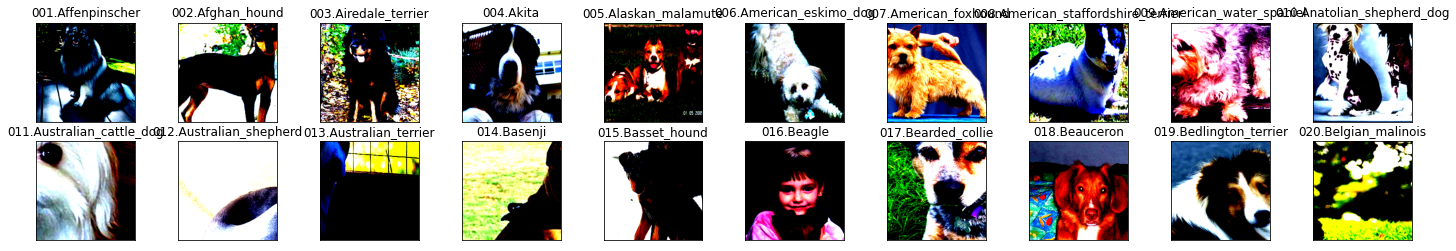

In [8]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title( dog_labels[idx])

# Define the model

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
n_dog_breeds = len(dog_labels)

class Net(nn.Module):
    def __init__(self):
      super().__init__()
      ## Define layers of a CNN
      l_channels = [3, 16 ,32, 64, 128]
      self.l_channels = l_channels
      self.conv1 = nn.Conv2d(in_channels = l_channels[0], out_channels = l_channels[1],
                            kernel_size = (3,3),padding = (1,1) )
      self.conv2 = nn.Conv2d(in_channels = l_channels[1], out_channels = l_channels[2] ,
                            kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(in_channels = l_channels[2], out_channels = l_channels[3] ,
                            kernel_size = 3, padding = 1)
      self.conv4 = nn.Conv2d(in_channels = l_channels[3], out_channels = l_channels[4] ,
                            kernel_size = 3, padding = 1)
      
      self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
      self.dropout = nn.Dropout(0.2)
      self.bn1 = nn.BatchNorm2d( l_channels[1], affine=True)      
      self.bn2 = nn.BatchNorm2d( l_channels[2], affine=True)      
      self.bn3 = nn.BatchNorm2d( l_channels[3], affine=True)      

      l_fc_size = [8000, 2048,1024 ]
      self.fc1 = nn.Linear(in_features = l_channels[4] * 14*14, out_features = l_fc_size[0])
      #self.fc2 = nn.Linear(in_features = l_fc_size[0] , out_features= n_dog_breeds)
      self.fc2 = nn.Linear(in_features = l_fc_size[0] , out_features=  l_fc_size[2])
      self.fc3 = nn.Linear(in_features = l_fc_size[2] , out_features=  n_dog_breeds)
        
    def forward(self, x) :
      ## Define forward behavior
      x = self.conv1(x)
      x = self.pool(x)
      x = F.relu(x)
      x = self.bn1(x)
      x = self.conv2(x)
      x = self.pool(x)
      x = F.relu(x)
      x = self.bn2(x)
      x = self.conv3(x)
      x = self.pool(x)
      x = F.relu(x)
      x = self.bn3(x)
      x = self.conv4(x)
      x = self.pool(x)
      x = F.relu(x)
      #print("end features layer shape : ", x.shape)
      x = x.view(x.shape[0],-1)
      #print("unroll shape :", x.shape)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = self.fc3(x)
      #x = F.relu(x)
      #x = self.fc4(x)
      return x

In [28]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [41]:
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [42]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=8000, bias=True)
  (fc2): Linear(in_features=8000, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
)


In [43]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001)

In [44]:
# number of epochs to train the model
n_epochs = 30
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):

  l_train_loss = np.empty(n_epochs)
  l_valid_loss = np.empty(n_epochs)
  l_train_accuracy = np.empty(n_epochs)
  l_valid_accuracy = np.empty(n_epochs)
  valid_loss_min = np.Inf 

  print("Begin Training")

  for epoch in range( n_epochs):
      # keep track of training and validation loss
      train_loss = 0.0
      correct = 0
      nsample = 0
      
      ###################
      # train the model #
      ###################
      # model by default is set to train
      model.train()
      for batch_i, (data, target) in enumerate(train_loader):
          # move tensors to GPU if CUDA is available
          if use_cuda:
              data, target = data.cuda(), target.cuda()
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update training loss 
          train_loss += loss.detach().item()*data.shape[0]
          estimated = output.data.max(1, keepdim=True)[1]
          correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
          nsample += data.shape[0]
      print('Epoch %d, loss: %.4f accuracy %.3f' %
            (epoch+1, train_loss / nsample, correct/float(nsample)))
      l_train_loss[epoch] = train_loss / nsample
      l_train_accuracy[epoch] = correct/float(nsample)
      train_loss = 0.0
      correct = 0
      nsample = 0
      with torch.no_grad():
          model.eval()
          valid_loss = 0.
          valid_nsample = 0
          valid_correct = 0
          for batch_i, (data, target) in enumerate(valid_loader):
              if use_cuda:
                  data, target = data.cuda(), target.cuda()
              output = model(data)
              loss = criterion(output, target)
              valid_loss += loss.item()*data.shape[0]
              estimated = output.data.max(1, keepdim=True)[1]
              valid_correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
              valid_nsample += data.shape[0]
          
          valid_loss /= valid_nsample
          print("VALID : Epoch %d,loss: %.4f accuracy %.3f" % 
                (epoch+1, valid_loss, valid_correct / float(valid_nsample) ) )  
          l_valid_loss[epoch] = valid_loss 
          l_valid_accuracy[epoch] = valid_correct / float(valid_nsample)
          if valid_loss < valid_loss_min:
              print("\tvalid loss decreased; save model")
              valid_loss_min = valid_loss
              torch.save(model.state_dict(), save_path)
  return model, l_train_loss, l_train_accuracy, l_valid_loss, l_valid_accuracy


In [45]:
 model, l_train_loss, l_train_accuracy, l_valid_loss, l_valid_accuracy = train(n_epochs, train_loader, valid_loader, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, "model_scratch.pt")

Begin Training
Epoch 1, loss: 4.8862 accuracy 0.011
VALID : Epoch 1,loss: 4.8767 accuracy 0.024
	valid loss decreased; save model
Epoch 2, loss: 4.8672 accuracy 0.012
VALID : Epoch 2,loss: 4.8591 accuracy 0.019
	valid loss decreased; save model
Epoch 3, loss: 4.8460 accuracy 0.022
VALID : Epoch 3,loss: 4.8360 accuracy 0.019
	valid loss decreased; save model
Epoch 4, loss: 4.8097 accuracy 0.020
VALID : Epoch 4,loss: 4.7871 accuracy 0.031
	valid loss decreased; save model
Epoch 5, loss: 4.7484 accuracy 0.034
VALID : Epoch 5,loss: 4.7165 accuracy 0.041
	valid loss decreased; save model
Epoch 6, loss: 4.6570 accuracy 0.038
VALID : Epoch 6,loss: 4.6241 accuracy 0.044
	valid loss decreased; save model
Epoch 7, loss: 4.5637 accuracy 0.044
VALID : Epoch 7,loss: 4.5775 accuracy 0.042
	valid loss decreased; save model
Epoch 8, loss: 4.4972 accuracy 0.045
VALID : Epoch 8,loss: 4.5388 accuracy 0.051
	valid loss decreased; save model
Epoch 9, loss: 4.4655 accuracy 0.052
VALID : Epoch 9,loss: 4.5181

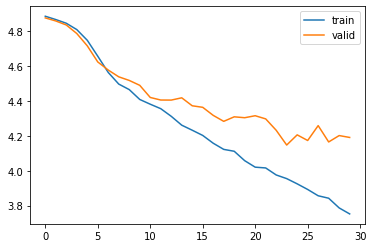

In [48]:
plt.plot(l_train_loss, label = 'train')
plt.plot(l_valid_loss, label = 'valid')
plt.legend()

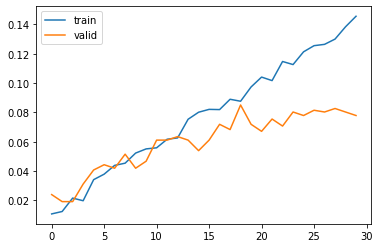

In [49]:
plt.plot(l_train_accuracy, label = 'train')
plt.plot(l_valid_accuracy, label = 'valid')
plt.legend()

In [53]:
def test_model(test_loader, model, criterion, use_cuda):
  with torch.no_grad():
      model.eval()
      test_loss = 0.
      test_nsample = 0
      test_correct = 0
      for batch_i, (data, target) in enumerate(test_loader):
          if use_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item()*data.shape[0]
          estimated = output.data.max(1, keepdim=True)[1]
          test_correct += np.sum(np.squeeze(estimated.eq(target.data.view_as(estimated))).cpu().numpy())
          test_nsample += data.shape[0]
  print("TEST : loss: %.4f accuracy %.3f" % 
        ( test_loss / test_nsample, test_correct / float(test_nsample) ) )  



In [54]:
test_model(test_loader, model, criterion_scratch, use_cuda)

TEST : loss: 4.2326 accuracy 0.063


In [55]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test_model(test_loader, model_scratch, criterion_scratch, use_cuda)

TEST : loss: 4.1857 accuracy 0.080
